In [2]:
# importing the required libraries and all
from sentenceSegmentation import SentenceSegmentation
from tokenization import Tokenization
from inflectionReduction import InflectionReduction
from stopwordRemoval import StopwordRemoval
from informationRetrieval import InformationRetrieval
from evaluation import Evaluation
from main import SearchEngine


import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pf
import seaborn as sns
import pandas as pd
from nltk.tokenize.treebank import TreebankWordTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats 

import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading the dataset
queries_json = json.load(open(".\cranfield\cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json], \
								[item["query"] for item in queries_json]
processedQueries = json.load(open('.\output\stopword_removed_queries.txt', 'r'))
docs_json = json.load(open(".\cranfield\cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json], \
								[item["body"] for item in docs_json]
processedDocs = json.load(open('.\output\stopword_removed_docs.txt', 'r'))
qrels = json.load(open("./cranfield/cran_qrels.json", "r"))[:]

In [4]:
docs[0]

'experimental investigation of the aerodynamics of a wing in a slipstream .   an experimental study of a wing in a propeller slipstream was made in order to determine the spanwise distribution of the lift increase due to slipstream at different angles of attack of the wing and at different free stream to slipstream velocity ratios .  the results were intended in part as an evaluation basis for different theoretical treatments of this problem .   the comparative span loading curves, together with supporting evidence, showed that a substantial part of the lift increment produced by the slipstream was due to a /destalling/ or boundary-layer-control effect .  the integrated remaining lift increment, after subtracting this destalling lift, was found to agree well with a potential flow theory .   an empirical evaluation of the destalling effects was made for the specific configuration of the experiment .'

In [5]:
from evaluation import Evaluation
evaluate = Evaluation()
def do_evaluation(docs_IDs_ordered, query_ids, qrels, title):
    precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []
    for k in range(1, 11):
        precision = evaluate.meanPrecision(docs_IDs_ordered, query_ids, qrels, k)
        precisions.append(precision)

        recall = evaluate.meanRecall(docs_IDs_ordered, query_ids, qrels, k)
        recalls.append(recall)

        fscore = evaluate.meanFscore(docs_IDs_ordered, query_ids, qrels ,k)
        fscores.append(fscore)

        print("Precision, Recall and F-score @ " +  
				str(k) + " : " + str(precision) + ", " + str(recall) + 
				", " + str(fscore))

        map = evaluate.meanAveragePrecision(docs_IDs_ordered, query_ids, qrels, k)
        MAPs.append(map)

        ndcg = evaluate.meanNDCG(docs_IDs_ordered, query_ids, qrels, k)
        nDCGs.append(ndcg)

        print("MAP, nDCG @ " +  
				str(k) + " : " + str(map) + ", " + str(ndcg))
    
    plt.plot(range(1, 11), precisions, label="Precision")
    plt.plot(range(1, 11), recalls, label="Recall")
    plt.plot(range(1, 11), fscores, label="F-Score")
    plt.plot(range(1, 11), MAPs, label="MAP")
    plt.plot(range(1, 11), nDCGs, label="nDCG")
    plt.legend()
    plt.title(title)
    plt.xlabel("k")
    return    



In [6]:
# basic vsm model
IR = InformationRetrieval()
IR.buildIndex(processedDocs, doc_ids)
doc_ids_ordered_vsm = IR.rank(processedQueries)

In [7]:
# query expansion
# taking tokens to train the word2vec model
import gensim
from gensim.models import Word2Vec
data = docs + queries
tokens = []
t = TreebankWordTokenizer()
for sentence in data:
    tokens.append(sentence.split(" "))
len(tokens)

1625

In [8]:
# Higher sample= Value: A higher sample value leads to less aggressive downsampling, meaning fewer words will be excluded from the training data based on frequency.
# Lower sample= Value: A lower sample value results in more aggressive downsampling, where more frequent words are more likely to be excluded from training.

In [9]:
# Skip-gram tends to perform well with rare words because it learns representations based on multiple contexts in which rare words appear.
# If your dataset includes uncommon or specialized vocabulary, skip-gram might be better suited to capture their meanings effectively.

In [10]:
# function to expand the queries
def query_expand(words, query, model):
    expanded_query = []
    lis = query.split(" ")
    for word in lis:
        try:
            expanded_query += ([similar_word[0] for similar_word in model.wv.most_similar([word], topn=words)])
        except KeyError:
            pass
        expanded_query += [word]
    ex_q = " ".join(expanded_query)
    return ex_q

Iteration 1
Precision, Recall and F-score @ 1 : 0.6133333333333333, 0.10414412710431352, 0.1709837367584856
MAP, nDCG @ 1 : 0.6133333333333333, 0.51
Precision, Recall and F-score @ 2 : 0.54, 0.17413969107967192, 0.2476062156247497
MAP, nDCG @ 2 : 0.6777777777777778, 0.47441280841570826
Precision, Recall and F-score @ 3 : 0.4814814814814817, 0.2244918112305751, 0.28570552279763656
MAP, nDCG @ 3 : 0.6855555555555556, 0.45669492694999286
Precision, Recall and F-score @ 4 : 0.4266666666666667, 0.2609333339904886, 0.3004799757773019
MAP, nDCG @ 4 : 0.6832098765432099, 0.4447964895894014
Precision, Recall and F-score @ 5 : 0.3777777777777782, 0.2844323331882709, 0.2998293491262848
MAP, nDCG @ 5 : 0.6742037037037036, 0.432731098671604
Precision, Recall and F-score @ 6 : 0.34074074074074057, 0.3057634170044122, 0.29707027115179374
MAP, nDCG @ 6 : 0.6677827160493827, 0.4291216415734037
Precision, Recall and F-score @ 7 : 0.31555555555555587, 0.32636851307029263, 0.29573438914496925
MAP, nDCG @ 

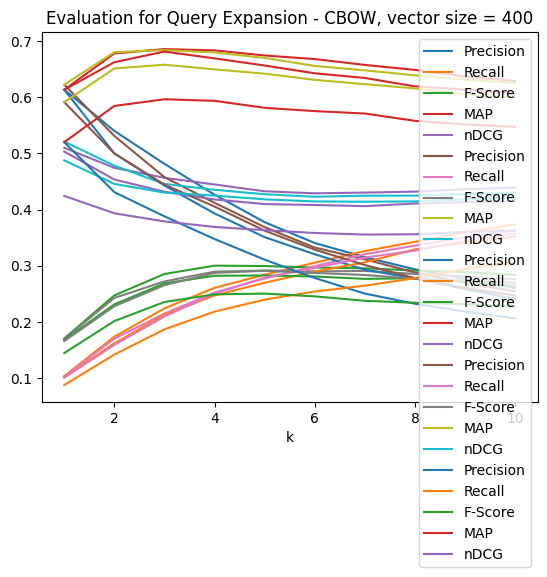

In [11]:
# finding results for cbow model
for i in range(5):
    wordvec1 = Word2Vec(sentences=tokens, vector_size = 400, window=3, min_count=1, sample=6e-5, sg=0)
    expanded_queries_1 = []
    for query in queries:
        expanded_queries_1.append(query_expand(1, query, wordvec1))
    vectorizer = TfidfVectorizer()
    expanded_corpus_1 = docs + expanded_queries_1
    X_1 = vectorizer.fit_transform(expanded_corpus_1)
    feature_names_1 = vectorizer.get_feature_names_out()
    col_count = len(docs)
    qe_tfidf_docs = X_1[:col_count, :].toarray()
    qe_tfidf_queries = X_1[col_count:, :].toarray()
    qe_cos_sim = np.matmul(qe_tfidf_docs, qe_tfidf_queries.T)
    sorted_indices = np.argsort(-qe_cos_sim, axis=0)
    qe_docIDs_ordered = (sorted_indices + 1).T.tolist()
    print("Iteration "+str(i+1))
    do_evaluation(qe_docIDs_ordered, query_ids, qrels, "Evaluation for Query Expansion - CBOW, vector size = 400")

Iteration 1
Precision, Recall and F-score @ 1 : 0.5155555555555555, 0.08323841163719455, 0.1381664317794348
MAP, nDCG @ 1 : 0.5155555555555555, 0.42333333333333334
Precision, Recall and F-score @ 2 : 0.4488888888888889, 0.14306229174086899, 0.20455627331336962
MAP, nDCG @ 2 : 0.5866666666666667, 0.40153777392031403
Precision, Recall and F-score @ 3 : 0.3985185185185182, 0.18750185531254898, 0.2373785440552305
MAP, nDCG @ 3 : 0.5970370370370369, 0.38649638388424723
Precision, Recall and F-score @ 4 : 0.3388888888888889, 0.20816772240526915, 0.23876102262230733
MAP, nDCG @ 4 : 0.5996296296296296, 0.36558592964220765
Precision, Recall and F-score @ 5 : 0.30755555555555597, 0.2322116286576378, 0.24456924183886072
MAP, nDCG @ 5 : 0.5897098765432098, 0.361149304427147
Precision, Recall and F-score @ 6 : 0.2799999999999999, 0.2550488284948377, 0.24651621538622076
MAP, nDCG @ 6 : 0.5800592592592592, 0.3593399596960753
Precision, Recall and F-score @ 7 : 0.26095238095238127, 0.27272476243743826

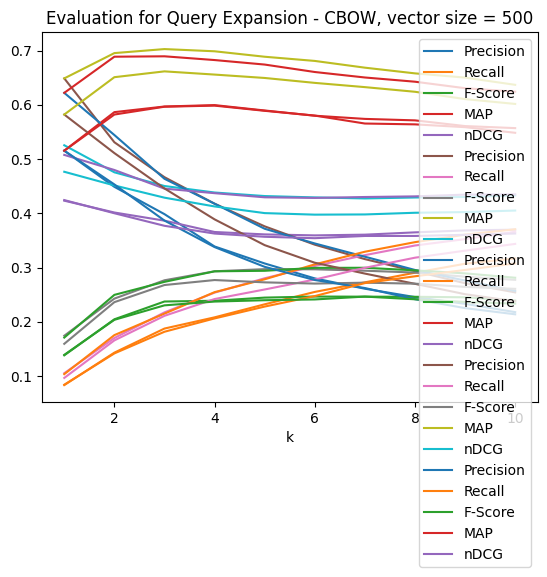

In [12]:
for i in range(5):
    wordvec1 = Word2Vec(sentences=tokens, vector_size = 500, window=3, min_count=1, sample=6e-5, sg=0)
    expanded_queries_1 = []
    for query in queries:
        expanded_queries_1.append(query_expand(1, query, wordvec1))
    vectorizer = TfidfVectorizer()
    expanded_corpus_1 = docs + expanded_queries_1
    X_1 = vectorizer.fit_transform(expanded_corpus_1)
    feature_names_1 = vectorizer.get_feature_names_out()
    col_count = len(docs)
    qe_tfidf_docs = X_1[:col_count, :].toarray()
    qe_tfidf_queries = X_1[col_count:, :].toarray()
    qe_cos_sim = np.matmul(qe_tfidf_docs, qe_tfidf_queries.T)
    sorted_indices = np.argsort(-qe_cos_sim, axis=0)
    qe_docIDs_ordered = (sorted_indices + 1).T.tolist()
    print("Iteration "+str(i+1))
    do_evaluation(qe_docIDs_ordered, query_ids, qrels, "Evaluation for Query Expansion - CBOW, vector size = 500")

In [13]:
# for skipwords it is coming for 300, 200
# for 200 with increased window size it decreased
# for window size = 3 best result

Iteration 1
Precision, Recall and F-score @ 1 : 0.6311111111111111, 0.10381019741744264, 0.17170212947687832
MAP, nDCG @ 1 : 0.6311111111111111, 0.5011111111111111
Precision, Recall and F-score @ 2 : 0.5088888888888888, 0.16814787853491817, 0.23851855484943843
MAP, nDCG @ 2 : 0.68, 0.45375371426527933
Precision, Recall and F-score @ 3 : 0.4488888888888888, 0.2128714760102399, 0.26998595564441696
MAP, nDCG @ 3 : 0.6814814814814814, 0.43214862995383785
Precision, Recall and F-score @ 4 : 0.39222222222222225, 0.24368804964520427, 0.2796071843304739
MAP, nDCG @ 4 : 0.6749382716049381, 0.4173999224113417
Precision, Recall and F-score @ 5 : 0.354666666666667, 0.2704112652821453, 0.28451546996947447
MAP, nDCG @ 5 : 0.6635370370370368, 0.4109447530833016
Precision, Recall and F-score @ 6 : 0.32, 0.2876200074373486, 0.2804321037472542
MAP, nDCG @ 6 : 0.651362962962963, 0.4073349903051135
Precision, Recall and F-score @ 7 : 0.2952380952380954, 0.3056174834669408, 0.278060584366858
MAP, nDCG @ 7 

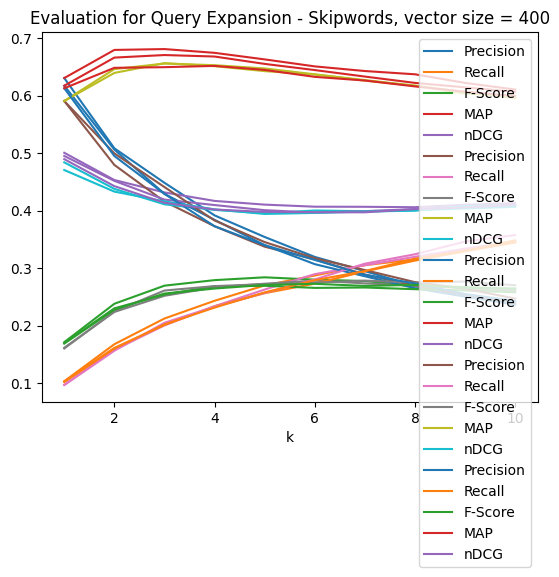

In [14]:
# finding results for skipwords model
for i in range(5):    
    wordvec2 = Word2Vec(sentences=tokens, vector_size = 400, window=3, min_count=1, sample=6e-5, sg=1) 
    expanded_queries_2 = []
    for query in queries:
        expanded_queries_2.append(query_expand(1, query, wordvec2))
    vectorizer = TfidfVectorizer()
    expanded_corpus_2 = docs + expanded_queries_2
    X_2 = vectorizer.fit_transform(expanded_corpus_2)
    col_count = len(docs)
    qe_tfidf_docs = X_2[:col_count, :].toarray()
    qe_tfidf_queries = X_2[col_count:, :].toarray()
    qe_cos_sim = np.matmul(qe_tfidf_docs, qe_tfidf_queries.T)
    sorted_indices = np.argsort(-qe_cos_sim, axis=0)
    qe_docIDs_ordered = (sorted_indices + 1).T.tolist()
    print("Iteration "+str(i+1))
    do_evaluation(qe_docIDs_ordered, query_ids, qrels, "Evaluation for Query Expansion - Skipwords, vector size = 400")

In [15]:
for i in range(5):    
    wordvec2 = Word2Vec(sentences=tokens, vector_size = 300, window=3, min_count=1, sample=6e-5, sg=1) 
    expanded_queries_2 = []
    for query in queries:
        expanded_queries_2.append(query_expand(1, query, wordvec2))
    vectorizer = TfidfVectorizer()
    expanded_corpus_2 = docs + expanded_queries_2
    X_2 = vectorizer.fit_transform(expanded_corpus_2)
    col_count = len(docs)
    qe_tfidf_docs = X_2[:col_count, :].toarray()
    qe_tfidf_queries = X_2[col_count:, :].toarray()
    qe_cos_sim = np.matmul(qe_tfidf_docs, qe_tfidf_queries.T)
    sorted_indices = np.argsort(-qe_cos_sim, axis=0)
    qe_docIDs_ordered = (sorted_indices + 1).T.tolist()
    print("Iteration "+str(i+1))
    do_evaluation(qe_docIDs_ordered, query_ids, qrels, "Evaluation for Query Expansion - Skipwords, vector size = 300")

KeyboardInterrupt: 

Iteration 1
Precision, Recall and F-score @ 1 : 0.6044444444444445, 0.10303491324742167, 0.16883139599830163
MAP, nDCG @ 1 : 0.6044444444444445, 0.48333333333333334
Precision, Recall and F-score @ 2 : 0.4955555555555556, 0.1609957785880814, 0.22924395194084862
MAP, nDCG @ 2 : 0.66, 0.44459247819341996
Precision, Recall and F-score @ 3 : 0.4237037037037037, 0.2026709705378045, 0.25566270417071063
MAP, nDCG @ 3 : 0.6607407407407409, 0.4173631485874954
Precision, Recall and F-score @ 4 : 0.38333333333333336, 0.2376967437249812, 0.2726729546452235
MAP, nDCG @ 4 : 0.6577777777777778, 0.40883107095878896
Precision, Recall and F-score @ 5 : 0.3457777777777783, 0.2622807548607165, 0.2761492355331992
MAP, nDCG @ 5 : 0.6485246913580247, 0.4017913634746024
Precision, Recall and F-score @ 6 : 0.31185185185185194, 0.2839896385696002, 0.2751625578859521
MAP, nDCG @ 6 : 0.6433592592592592, 0.3989185092477008
Precision, Recall and F-score @ 7 : 0.28761904761904783, 0.30006747982783366, 0.2716798492000

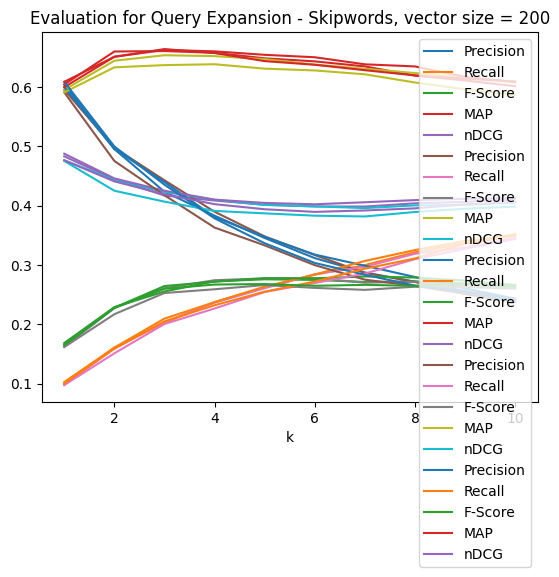

In [ ]:
for i in range(5):    
    wordvec2 = Word2Vec(sentences=tokens, vector_size = 200, window=3, min_count=1, sample=6e-5, sg=1) 
    expanded_queries_2 = []
    for query in queries:
        expanded_queries_2.append(query_expand(1, query, wordvec2))
    vectorizer = TfidfVectorizer()
    expanded_corpus_2 = docs + expanded_queries_2
    X_2 = vectorizer.fit_transform(expanded_corpus_2)
    col_count = len(docs)
    qe_tfidf_docs = X_2[:col_count, :].toarray()
    qe_tfidf_queries = X_2[col_count:, :].toarray()
    qe_cos_sim = np.matmul(qe_tfidf_docs, qe_tfidf_queries.T)
    sorted_indices = np.argsort(-qe_cos_sim, axis=0)
    qe_docIDs_ordered = (sorted_indices + 1).T.tolist()
    print("Iteration "+str(i+1))
    do_evaluation(qe_docIDs_ordered, query_ids, qrels, "Evaluation for Query Expansion - Skipwords, vector size = 200")

In [16]:
def testing(qrels, doc_IDs_ordered, k):
    # calculate query precision, recall, Fscore, nDCG for each query and store in array
    eval_test = Evaluation()
    q_prec = []
    q_recall = []
    q_fscore = []
    q_nDCG = []
    df = pd.DataFrame(qrels)
    for i in range(len(doc_IDs_ordered)):
        query_doc_IDs_ordered = doc_IDs_ordered[i]
        true_doc_IDs = list(map(int, df[df['query_num'] == str(i+1)]['id'].tolist()))
        
        precision = eval_test.queryPrecision(query_doc_IDs_ordered, i+1, true_doc_IDs, k)
        q_prec.append(precision)
        recall = eval_test.queryRecall(query_doc_IDs_ordered, i+1, true_doc_IDs, k)
        q_recall.append(recall)
        fscore = eval_test.queryFscore(query_doc_IDs_ordered, i+1, true_doc_IDs, k)
        q_fscore.append(fscore)
        
    for j in range(len(doc_IDs_ordered)):
        query_doc_IDs_ordered = doc_IDs_ordered[j]
        true_doc_IDs_nDCG = list(map(int, df[df['query_num'] == str(j+1)]['id'].tolist()))
        print(true_doc_IDs_nDCG)
        print(query_doc_IDs_ordered)
        nDCG = eval_test.queryNDCG(query_doc_IDs_ordered, j+1, true_doc_IDs_nDCG, k)
        print(nDCG)
        q_nDCG.append(nDCG)

    return q_prec, q_recall, q_fscore, q_nDCG

In [17]:
# hypothesis testing function a vs b
def hypothesis_test(a, b):
    n = len(a)
    mean_a = np.mean(a)
    mean_b = np.mean(b)
    var_a = np.var(a)
    var_b = np.var(b)
    t = (mean_a - mean_b) / np.sqrt(var_a/n + var_b/n)

    # also p value
    p = 1 - stats.t.cdf(t, n-1)
    return t, p


In [18]:
wordvec1 = Word2Vec(sentences=tokens, vector_size = 500, window=3, min_count=1, sample=6e-5, sg=0)
expanded_queries_1 = []
for query in queries:
    expanded_queries_1.append(query_expand(1, query, wordvec1))
vectorizer = TfidfVectorizer()
expanded_corpus_1 = docs + expanded_queries_1
X_1 = vectorizer.fit_transform(expanded_corpus_1)
feature_names_1 = vectorizer.get_feature_names_out()
col_count = len(docs)
qe_tfidf_docs = X_1[:col_count, :].toarray()
qe_tfidf_queries = X_1[col_count:, :].toarray()
qe_cos_sim = np.matmul(qe_tfidf_docs, qe_tfidf_queries.T)
sorted_indices = np.argsort(-qe_cos_sim, axis=0)
qe_docIDs_ordered = (sorted_indices + 1).T.tolist()


In [19]:
q_prec_vsm, q_recall_vsm, q_fscore_vsm, q_nDCG_vsm = testing(qrels, doc_ids_ordered_vsm, 7)
q_prec_qe, q_recall_qe, q_fscore_qe, q_nDCG_qe = testing(qrels, qe_docIDs_ordered, 7)

[184, 29, 31, 12, 51, 102, 13, 14, 15, 57, 378, 859, 185, 30, 37, 52, 142, 195, 875, 56, 66, 95, 462, 497, 858, 876, 879, 880, 486]
[51, 359, 746, 12, 56, 944, 879, 878, 573, 486, 1186, 13, 253, 817, 1361, 874, 14, 663, 584, 665, 875, 141, 818, 332, 435, 792, 414, 184, 1169, 102, 172, 1144, 747, 781, 1149, 1328, 100, 78, 491, 378, 758, 876, 429, 884, 925, 1194, 104, 25, 685, 329, 316, 29, 395, 800, 219, 305, 526, 540, 202, 606, 1163, 1191, 1034, 284, 252, 1003, 592, 1155, 1121, 240, 415, 982, 5, 1168, 1048, 585, 1042, 158, 374, 251, 686, 193, 707, 729, 563, 811, 114, 261, 497, 294, 1184, 728, 1201, 280, 546, 1165, 1331, 1158, 1128, 300, 726, 640, 1212, 431, 220, 629, 456, 687, 180, 327, 681, 719, 390, 1268, 657, 542, 1332, 1147, 1372, 1050, 1263, 1167, 120, 700, 1334, 309, 315, 214, 883, 1305, 509, 522, 142, 62, 306, 601, 1198, 860, 1197, 57, 1335, 1164, 1261, 358, 328, 1380, 1026, 1207, 1181, 216, 195, 52, 756, 593, 349, 917, 370, 235, 453, 951, 666, 69, 630, 554, 541, 472, 634, 799, 

In [20]:
# hypothesis testing
t_prec, p_prec = hypothesis_test(q_prec_vsm, q_prec_qe)
t_recall, p_recall = hypothesis_test(q_recall_vsm, q_recall_qe)
t_fscore, p_fscore = hypothesis_test(q_fscore_vsm, q_fscore_qe)
t_nDCG, p_nDCG = hypothesis_test(q_nDCG_vsm, q_nDCG_qe)

print("Precision: t = ", t_prec, ", p = ", p_prec)
print("Recall: t = ", t_recall, ", p = ", p_recall)
print("Fscore: t = ", t_fscore, ", p = ", p_fscore)
print("nDCG: t = ", t_nDCG, ", p = ", p_nDCG)

Precision: t =  2.100010536411478 , p =  0.018423467907634827
Recall: t =  2.1770163650010823 , p =  0.015262142173226634
Fscore: t =  2.359729084294123 , p =  0.009573724696828934
nDCG: t =  1.5496590452370413 , p =  0.06131752279905167
